In [1]:
%matplotlib inline
import numpy as np
from numpy import random

# dimensionality reduction and visualization
import anndata as ad
from scanpy.api.tl import diffmap
import matplotlib.pyplot as plt

# make sure to use viridis as the default color map
import matplotlib as mpl

In [42]:
from prosstt import tree
from prosstt import simulation as sim
from prosstt import sim_utils as sut

import newick

In [43]:
# set random seed
rseed = 1992
random.seed(rseed)

In [44]:
newick_string = "(A:80,B:80)C:80;"
G = 500
lineage = tree.Tree.from_newick(newick_string, genes=G)

uMs, Ws, Hs = sim.simulate_lineage(lineage, a=0.05)
gene_scale = sut.simulate_base_gene_exp(lineage, uMs)
lineage.add_genes(uMs, gene_scale)

/home/npapado/miniconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [45]:
alpha1 = np.exp(random.normal(loc=np.log(0.2), scale=np.log(1.5), size=lineage.G))
beta1 = np.exp(random.normal(loc=np.log(1), scale=np.log(1.5), size=lineage.G)) + 1

X1, labs1, brns1, scalings1 = sim.sample_whole_tree(lineage, 1, alpha=alpha1, beta=beta1)

# normalize gene expression by library size
X1 = (X1.transpose() / scalings1).transpose()

make branch A be much sparser

In [46]:
tree_density = lineage.default_density()
density_offset = tree_density['C'][0] * 3/5
tree_density['A'] = tree_density['A'] - density_offset
tree_density['B'] = tree_density['B'] + density_offset # this means that B is denser than C, the "original" root
lineage.density = tree_density

In [47]:
X2, labs2, brns2, scalings2 = sim.sample_density(lineage, 150, alpha=alpha1, beta=beta1)

# normalize gene expression by library size
X2 = (X2.transpose() / scalings2).transpose()

sample via a pseudotime series

In [48]:
X3, labs3, brns3, scalings3 = sim.sample_pseudotime_series(lineage, cells=150,
                                                           series_points=[10, 80, 150],
                                                           point_std=[2, 5, 2],
                                                           alpha=alpha1, beta=beta1)

X3 = (X3.transpose() / scalings3).transpose()

In [49]:
data1 = ad.AnnData(X1)
diffmap(adata=data1)
dm1 = data1.obsm["X_diffmap"]
br_names1, indices1 = np.unique(brns1, return_inverse=True)

data2 = ad.AnnData(X2)
diffmap(adata=data2)
dm2 = data2.obsm["X_diffmap"]
br_names2, indices2 = np.unique(brns2, return_inverse=True)

data3 = ad.AnnData(X3)
diffmap(adata=data3)
dm3 = data3.obsm["X_diffmap"]
br_names3, indices3 = np.unique(brns3, return_inverse=True)

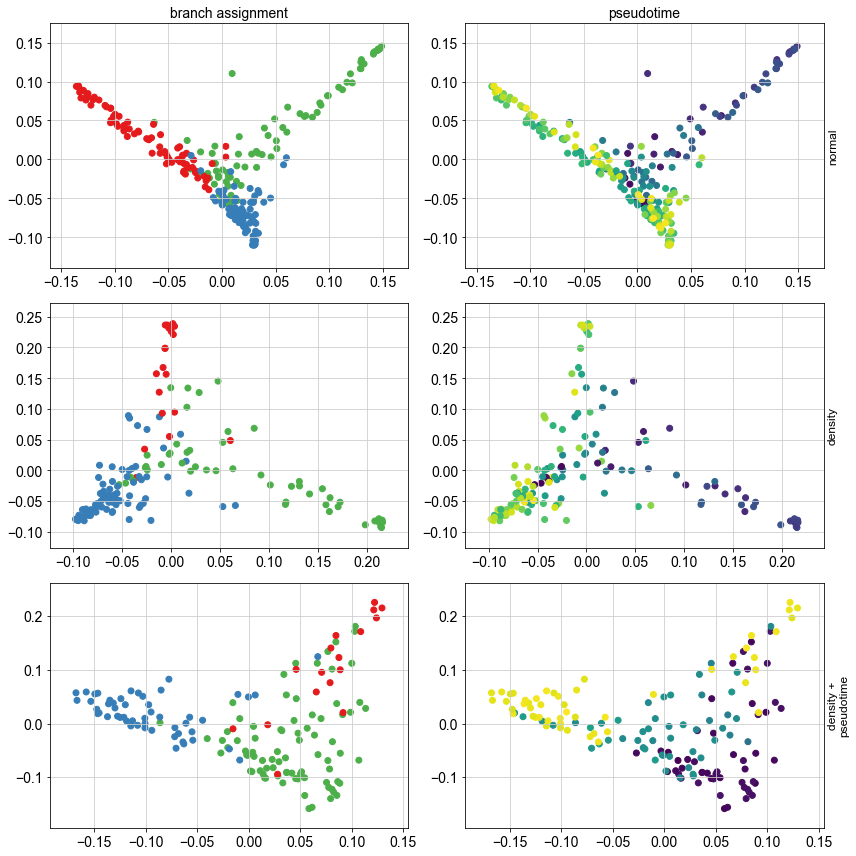

In [50]:
mpl.rcParams['image.cmap'] = 'viridis'
cmap = plt.cm.get_cmap("Set1")

fig, ax = plt.subplots(ncols=2, nrows=3)
fig.set_size_inches(w=12, h=12)
ax[0][0].scatter(dm1[:, 0], dm1[:, 1], c=cmap(indices1))
ax[0][1].scatter(dm1[:, 0], dm1[:, 1], c=labs1)
ax[1][0].scatter(dm2[:, 0], dm2[:, 1], c=cmap(indices2))
ax[1][1].scatter(dm2[:, 0], dm2[:, 1], c=labs2)
ax[2][0].scatter(dm3[:, 0], dm3[:, 1], c=cmap(indices3))
ax[2][1].scatter(dm3[:, 0], dm3[:, 1], c=labs3)

ax[0][0].set_title("branch assignment")
ax[0][1].set_title("pseudotime")

ax[0][1].yaxis.set_label_position("right")
ax[0][1].set_ylabel("normal", rotation=90, size='large')
ax[1][1].yaxis.set_label_position("right")
ax[1][1].set_ylabel("density", rotation=90, size='large')
ax[2][1].yaxis.set_label_position("right")
ax[2][1].set_ylabel("density +\npseudotime", rotation=90, size='large')

fig.tight_layout()

plt.show()